<br>
<u>Notebook Seventeen</u> | 
<a href=https://github.com/andrealeone/NLP target=_blank>Repository</a>
<br><br>
<b>Personality Traits Exploration</b><br><br>
Andrea Leone<br>
University of Trento<br>
April 2022
<br><br>

In [1]:
import project 

import spacy
import numpy             as np
import pandas            as pd
import sklearn
import sklearn.decomposition
import sklearn.manifold
import sklearn.cluster
import matplotlib
import matplotlib.pyplot as plt
import networkx          as nx
import grave
import pickle
import json
import os
import collections

from transformers  import pipeline
from tqdm.notebook import tqdm

In [2]:
records = project.sql_query(""" 
    SELECT * FROM talks
    WHERE annotations_p IS NOT NULL
    ORDER BY slug ASC;
""")

df = project.create_dataframe_from(records)

<br>Organise the personality descriptors for the "Big Five" traits and store traits and indices for the classifier

In [3]:
personality = { 
    #Trait               |  Positive                   |  Negative 
    "openness":          [ "inventive", "curious",       "consistent",  "cautious"  ],
    "conscientiousness": [ "efficient", "organized",     "extravagant", "careless"  ],
    "extraversion":      [ "outgoing",  "energetic",     "solitary",    "reserved"  ],
    "agreeableness":     [ "friendly",  "compassionate", "critical",    "rational"  ],
    "neuroticism":       [ "sensitive", "nervous",       "resilient",   "confident" ]
}

personality_traits = list(personality.keys())
traits = list(); indices = list() 

for trait, values in personality.items():
    traits.extend(values)
    indices.extend([trait]*4)

<br><br><b>Personality Heatmaps</b>

In [4]:
tags = [ 
    'culture', 'science', 'innovation', 'education', 'technology',
    'society', 'global issues', 'social change', 'justice system',
    'history', 'business', 'health', 'compassion', 'disability',
    'creativity', 'lgbtqia+', 'identity', 'humanity',
    'politics', 'economics', 'sustainability', 'future',
    'environment', 'biology', 'nature', 'climate change',
    'design', 'art', 'music', 'entertainment', 'empathy'
]; scores = list()

for tag in tags: 
    
    results = collections.Counter(); cnt = 0
    
    for annotations in df[ df.apply(lambda x : tag in x["tags"], axis=1) ]["annotations_p"]: 
        results.update( collections.Counter(
            dict( [ [t,v] for _,t,v in annotations["single"] ] )
        )); cnt += 1
    
    scores.append(np.array( list(results.values()) ) / cnt)

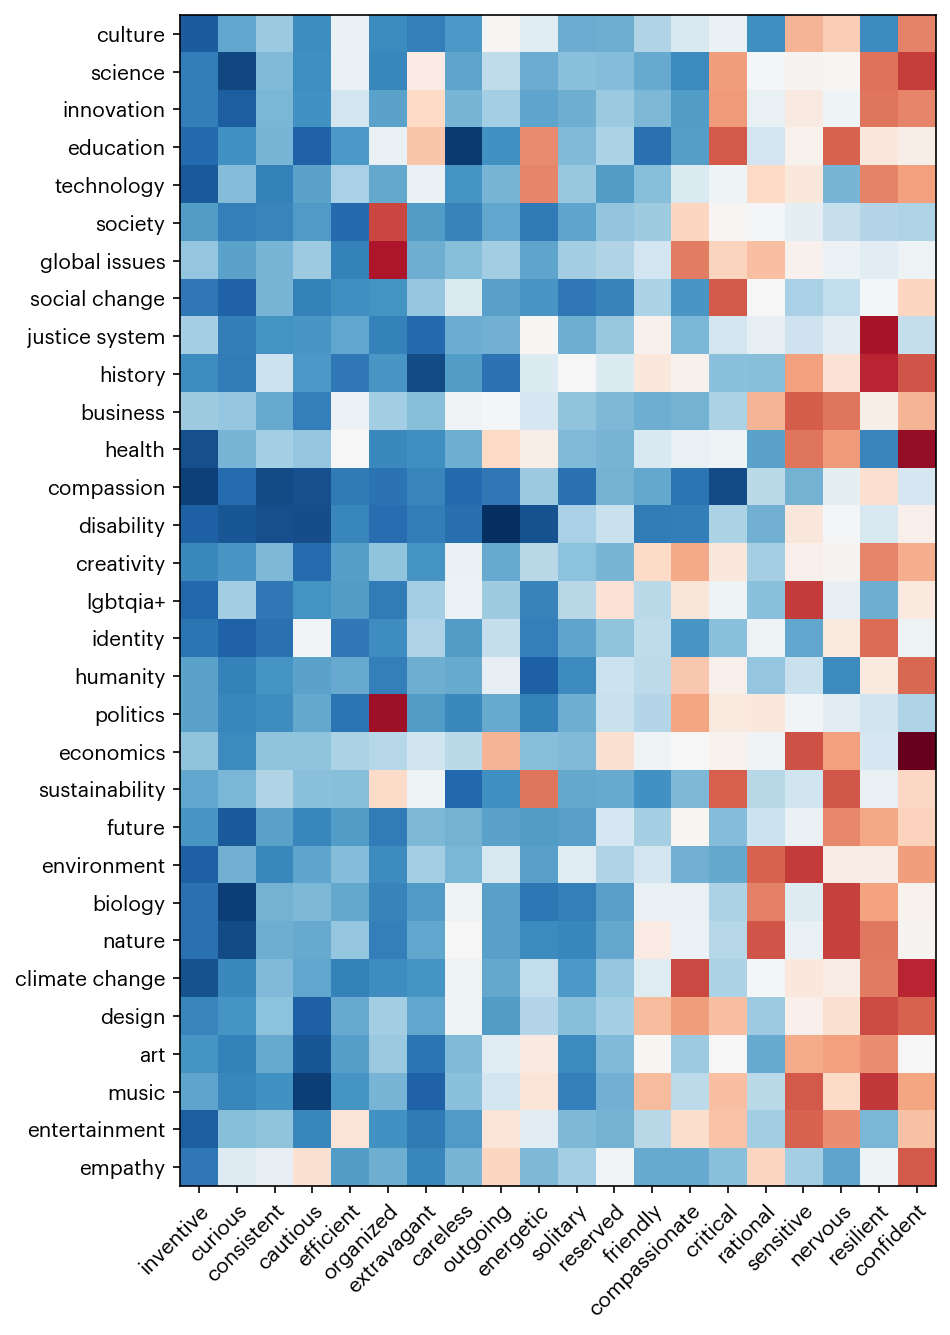

In [5]:
plt.rcParams["font.family"]    = "Graphik" 
plt.rcParams["figure.figsize"] = [ 20.0, 9.0 ]
plt.rcParams["figure.dpi"]     =  150

fig, ax = plt.subplots()
im = ax.imshow(scores, cmap=plt.get_cmap("RdBu"))

ax.set_xticks(np.arange( len(traits) ), labels=traits)
ax.set_yticks(np.arange( len(tags)   ), labels=tags)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fig.tight_layout()
plt.show()

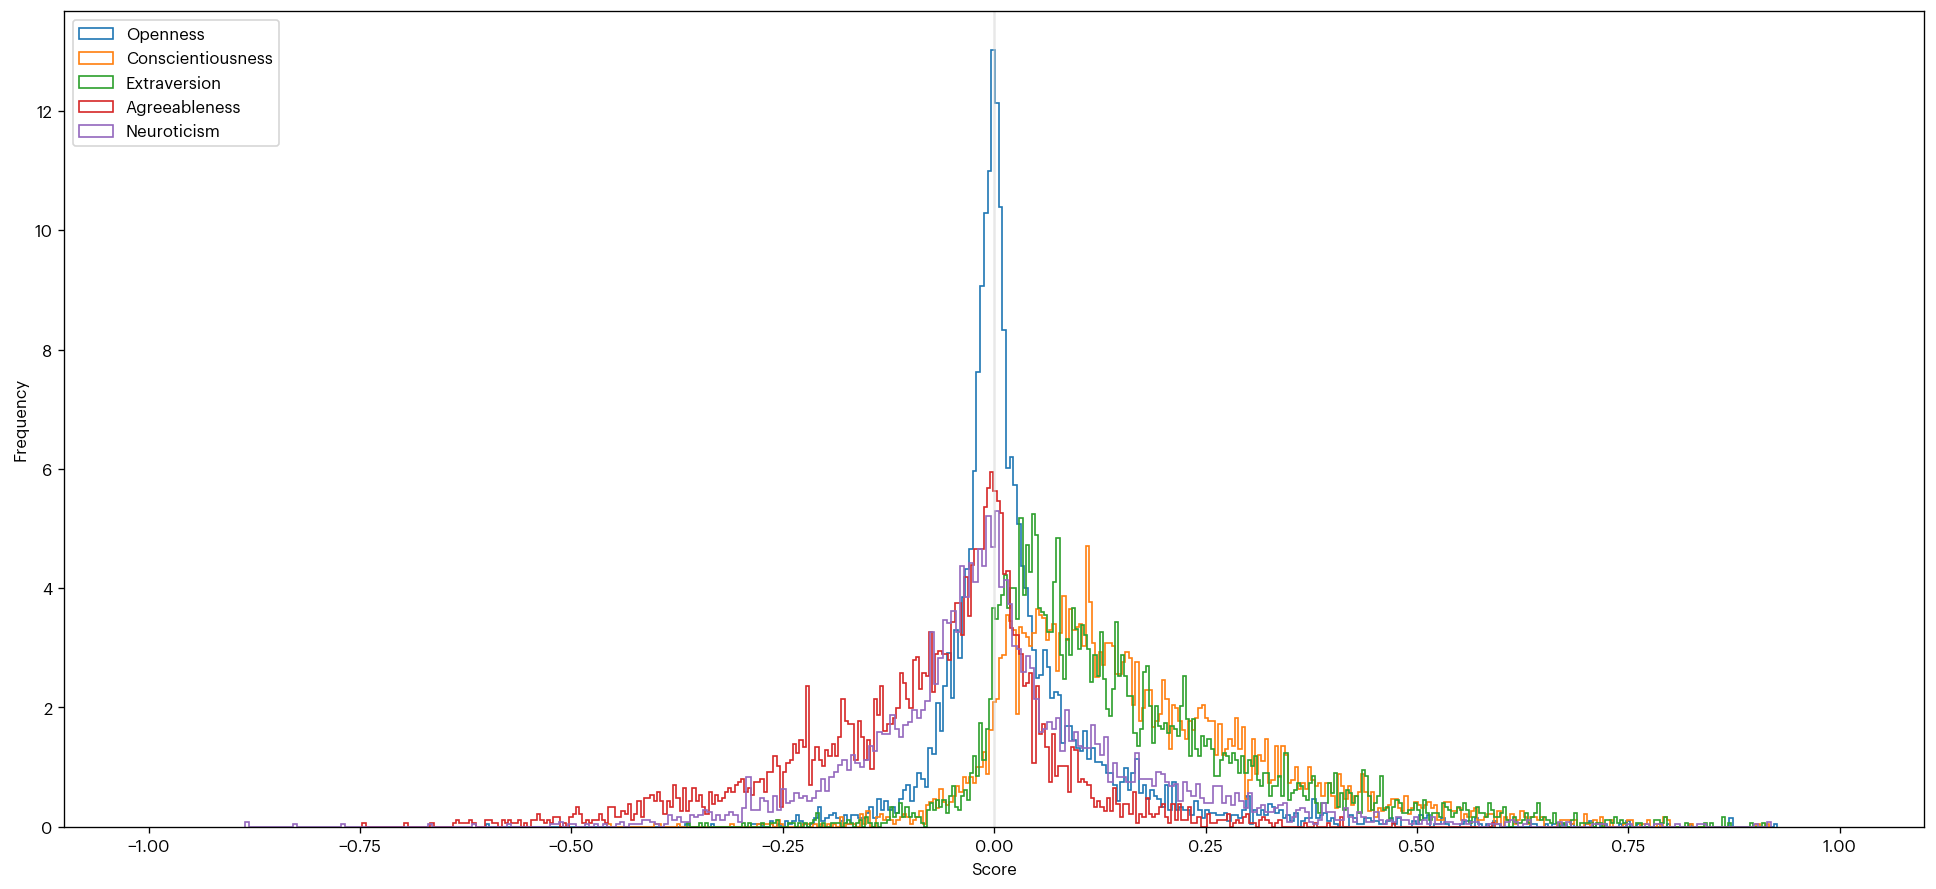

In [6]:
plt.rcParams["font.family"]    = "Graphik" 
plt.rcParams["figure.figsize"] = [ 20.0, 9.0 ]
plt.rcParams["figure.dpi"]     =  120

for i,t in enumerate(personality_traits): 

    plt.hist([
        row["annotations_p"]["aggregated"][i][1] for _,row in df.iterrows()
    ], bins=350, density=True, histtype="step", label=t.capitalize())

plt.xlim(-1.1, 1.1); plt.legend()
plt.axvline(x=0, color="lightgray", alpha=0.5)
plt.gca().set(
    xlabel="Score", ylabel="Frequency"
); plt.show()

<br><br><b>Personality clusters</b>

In [7]:
samples = list(df.iterrows())
dts = list(); dta = list(); ctg = list(); mxs = list()

for _,row in samples:
    ps  = np.array([v for c,l,v in row["annotations_p"]["single"]]);     dts.append(ps)
    pa  = np.array([v for l,v   in row["annotations_p"]["aggregated"]]); dta.append(pa)
    ctg.append( int(row["category"]) )
    mxs.append( pa.argmax() )

<br>Define PCA logic for matrix compression

In [8]:
pca    = lambda X : sklearn.decomposition.PCA(n_components=2).fit_transform(X) 

<br>Define K-Means and T-SNE logic for clustering

In [9]:
kms    = lambda X : sklearn.cluster.KMeans(n_clusters=5, random_state=42).fit_predict(X) 
tsne   = lambda X : sklearn.manifold.TSNE( 
    n_components=2, init="random", random_state=24, learning_rate=150
).fit_transform(X) 

<br>Apply T-SNE and unzip the 2D coordinates

In [10]:
points = tsne(dta) 
X,Y    = project.unzip_array(points) 

<br>Set plot configuration and show the peaked personality traits

In [11]:
plt.rcParams["font.family"]    = "Graphik" 
plt.rcParams["figure.figsize"] = [ 20.0, 9.0 ]
plt.rcParams["figure.dpi"]     =  150

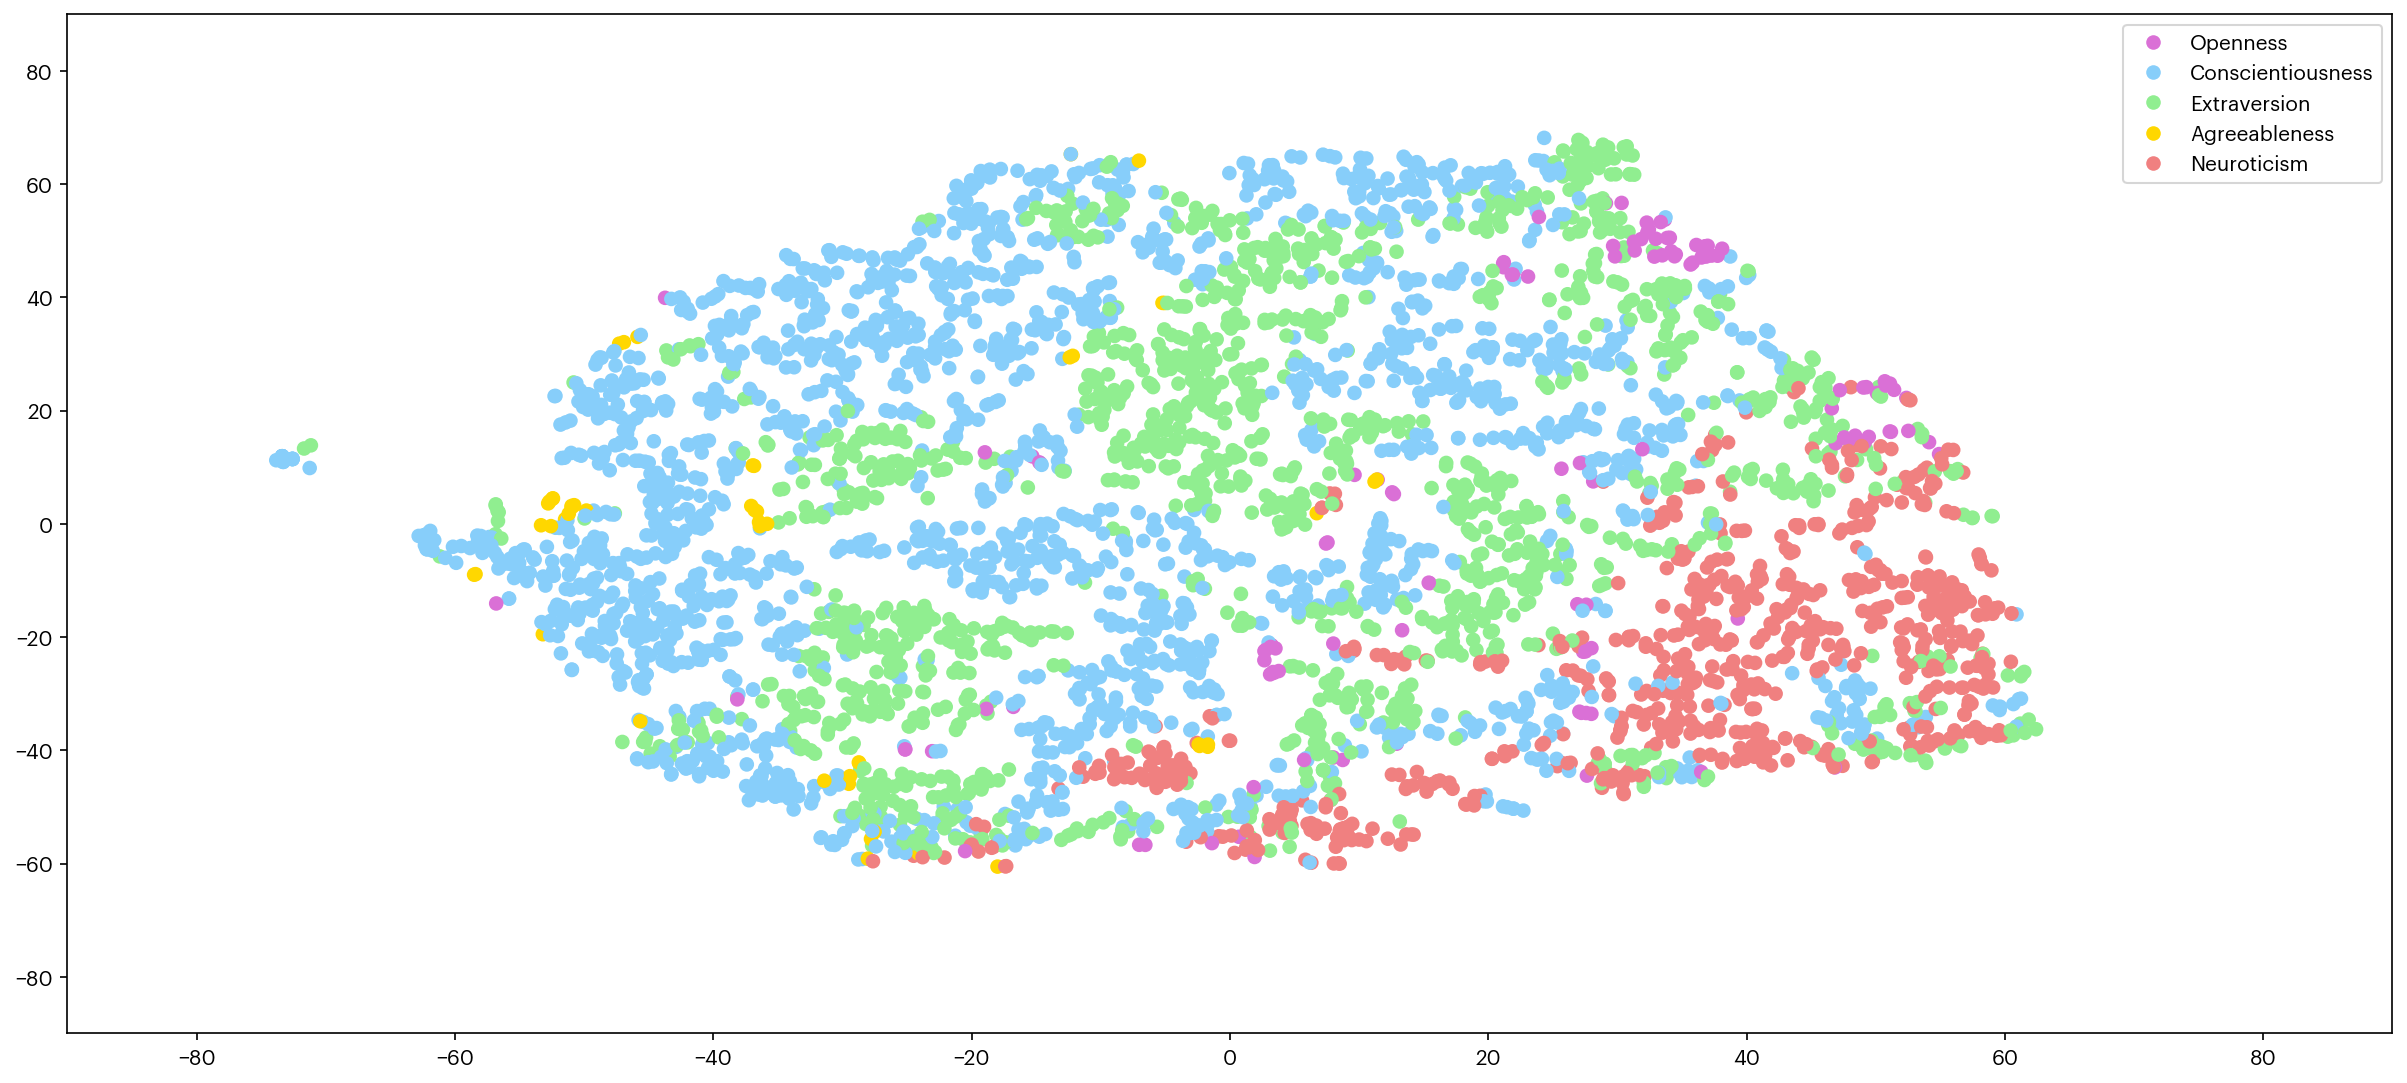

In [12]:
cls = [ "orchid", "lightskyblue", "lightgreen", "gold", "lightcoral" ] 
hdl = [
    matplotlib.lines.Line2D([0], [0], marker="o", color="w",
        label=personality_traits[i].capitalize(), markerfacecolor=cls[i], markersize=8
    ) for i in range(5)
]

plt.xlim(-90, 90)
plt.ylim(-90, 90)

plt.scatter(X, Y, c=[cls[v] for v in mxs])
plt.legend(handles=hdl)
plt.show()

<br>For reference, plot the talks of the previous plot highlighting the semantic category previously computed

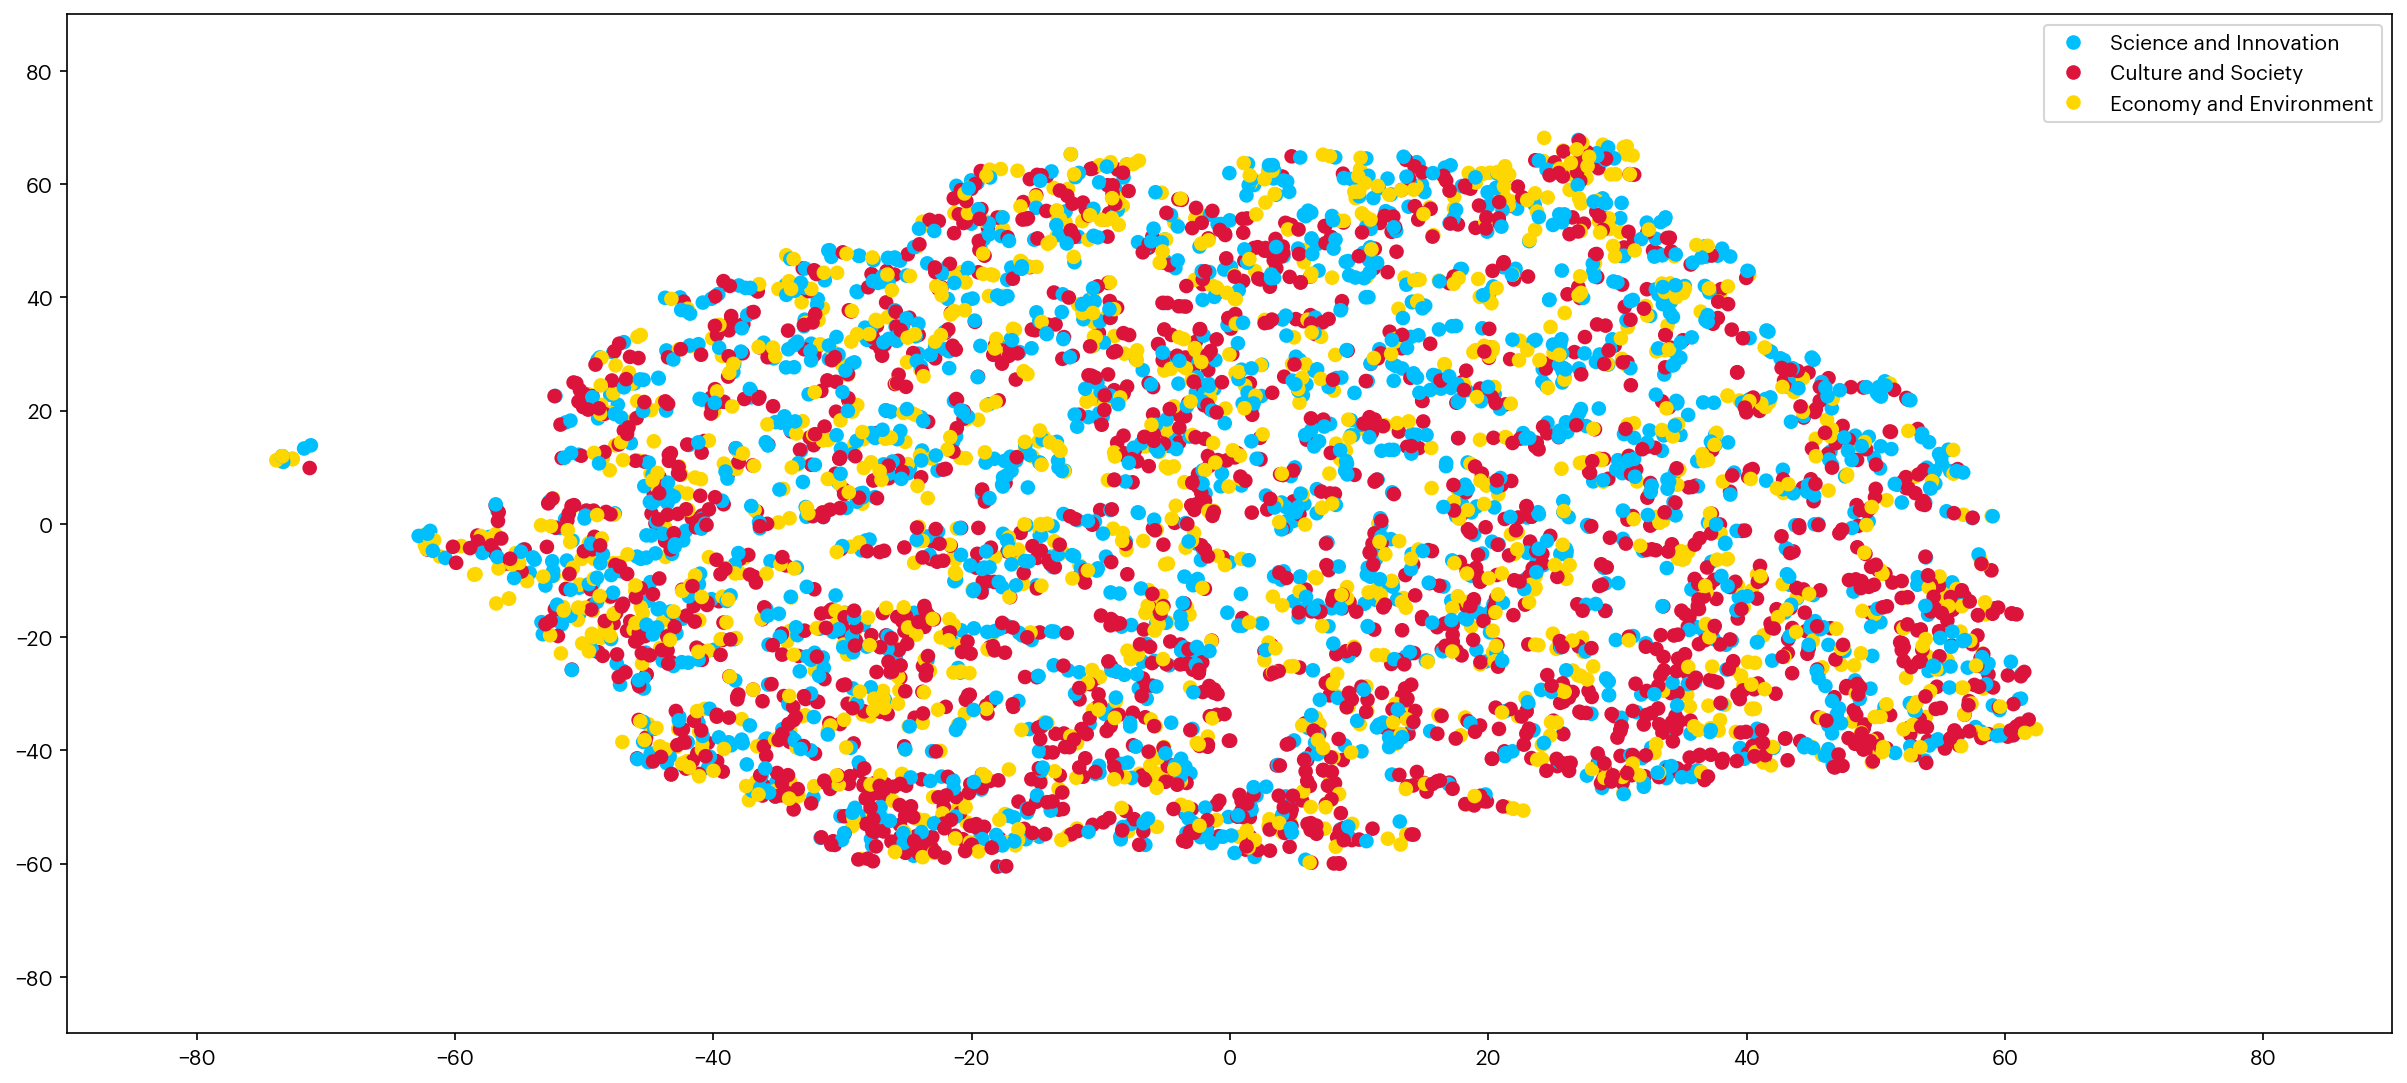

In [13]:
lbs = [ "Science and Innovation", "Culture and Society", "Economy and Environment"] 
cls = [ "deepskyblue", "crimson", "gold" ]; aps = [ 1,1,1 ]
hdl = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='w',
        label=lbs[i], markerfacecolor=cls[i], markersize=8
    ) for i in range(3)
]

plt.xlim(-90, 90)
plt.ylim(-90, 90)

plt.scatter(X, Y, c=[cls[v] for v in ctg], alpha=[aps[v] for v in ctg])
plt.legend(handles=hdl)
plt.show()

<br>Clusterise the talks based on the personality trait data

In [14]:
nc = 8 # Arbitrary, rather good 

In [15]:
clusters = sklearn.cluster.AgglomerativeClustering(n_clusters=nc).fit(points) 

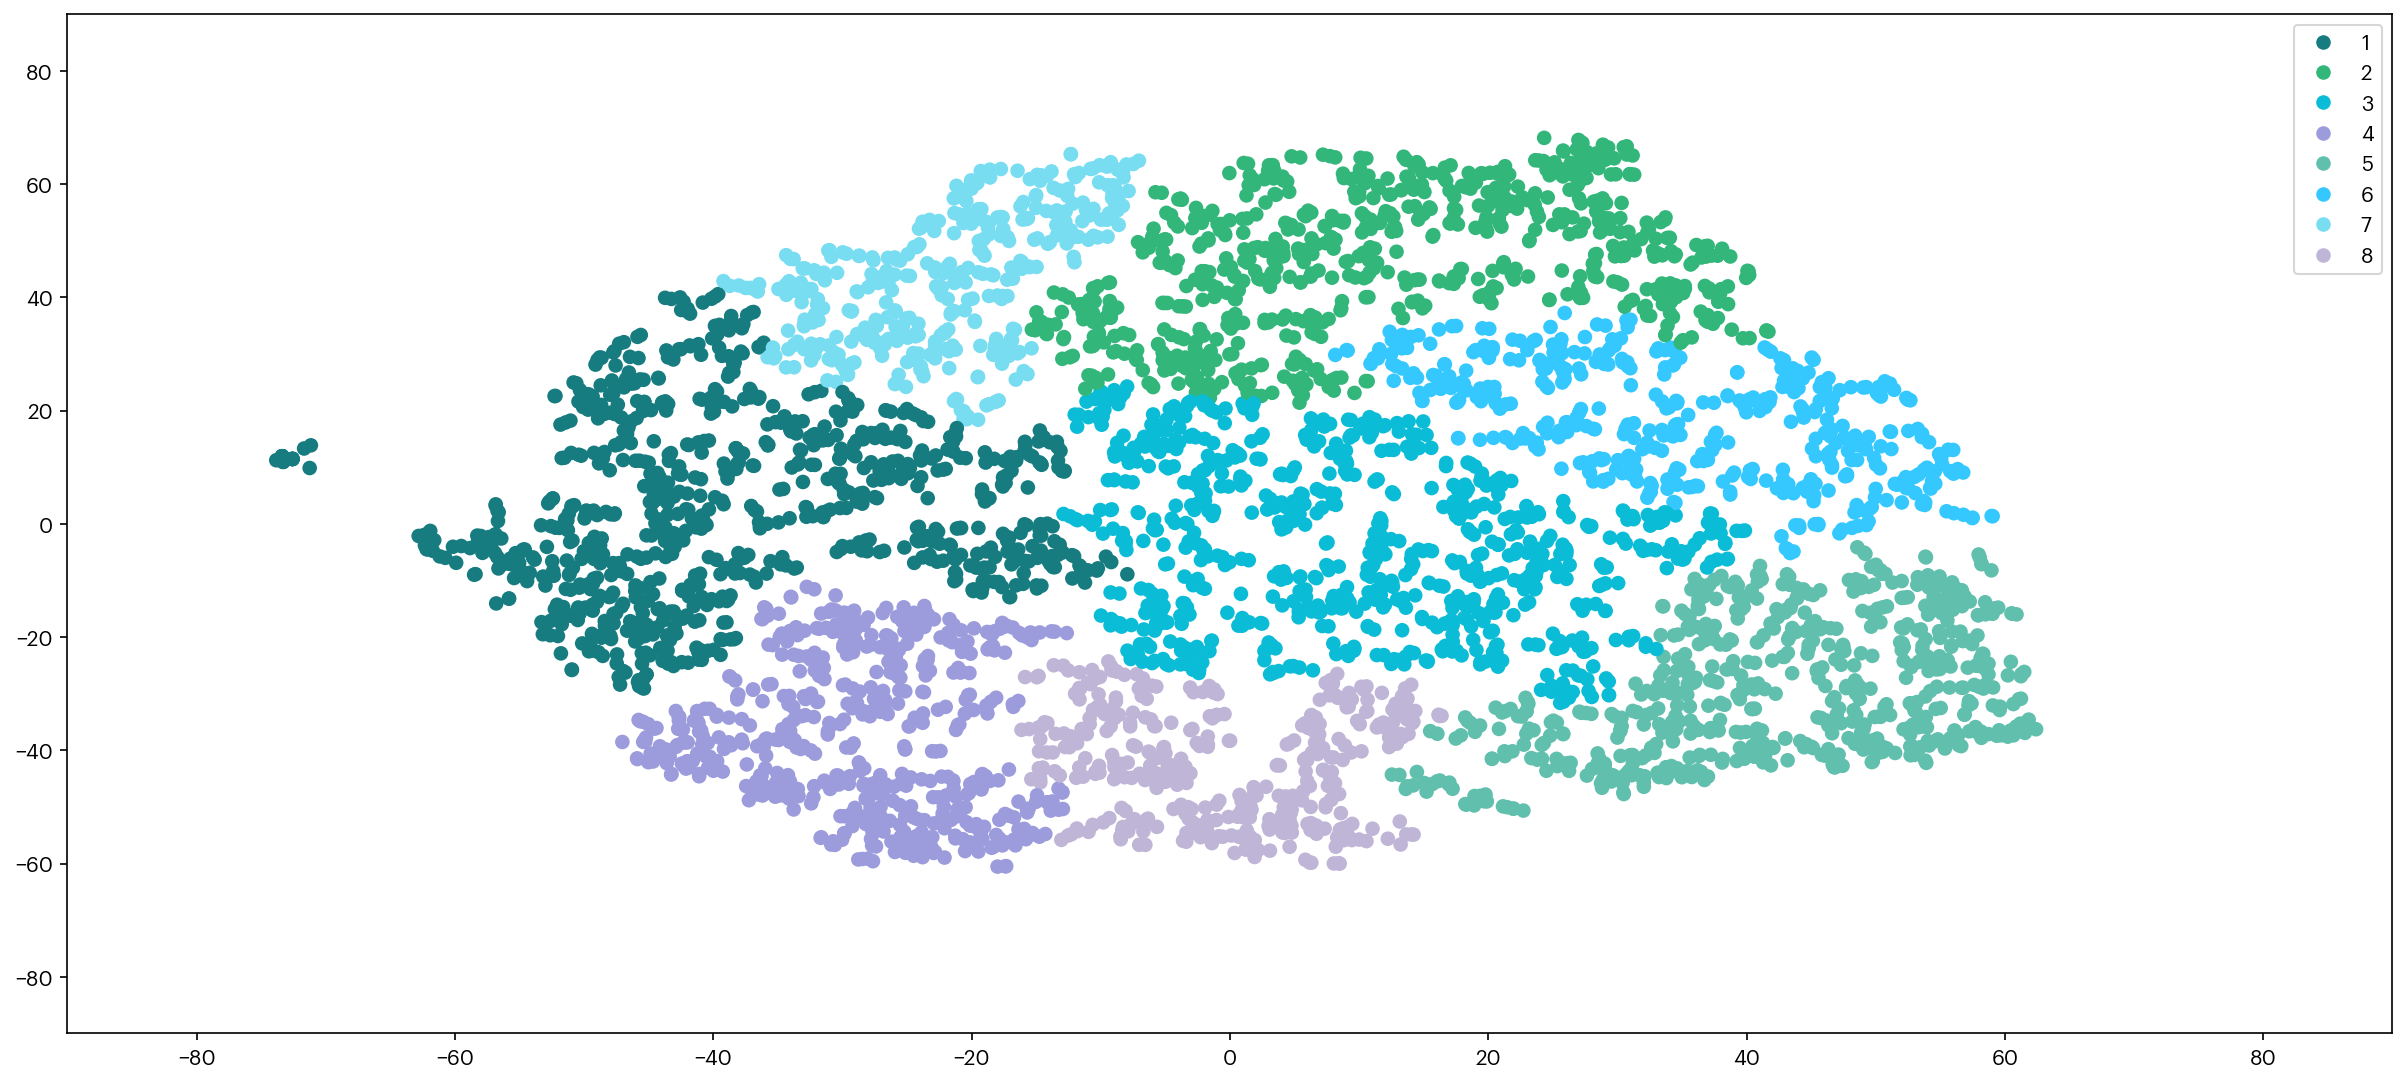

In [16]:
cls = [ "#167C80", "#32B67A", "#0BBCD6", "#9C9CDD", "#61BFAD", "#34C8FF", "#79DDF2", "#BFB5D7" ] 
hdl = [
    matplotlib.lines.Line2D([0], [0], marker="o", color="w",
        label=i+1, markerfacecolor=cls[i], markersize=8
    ) for i in range(8)
]

plt.xlim(-90, 90)
plt.ylim(-90, 90)

plt.scatter(X, Y, c=[cls[l] for l in clusters.labels_])
plt.legend(handles=hdl)
plt.show()

<br>Adjust the dot size of the talk reflecting the relative view counts

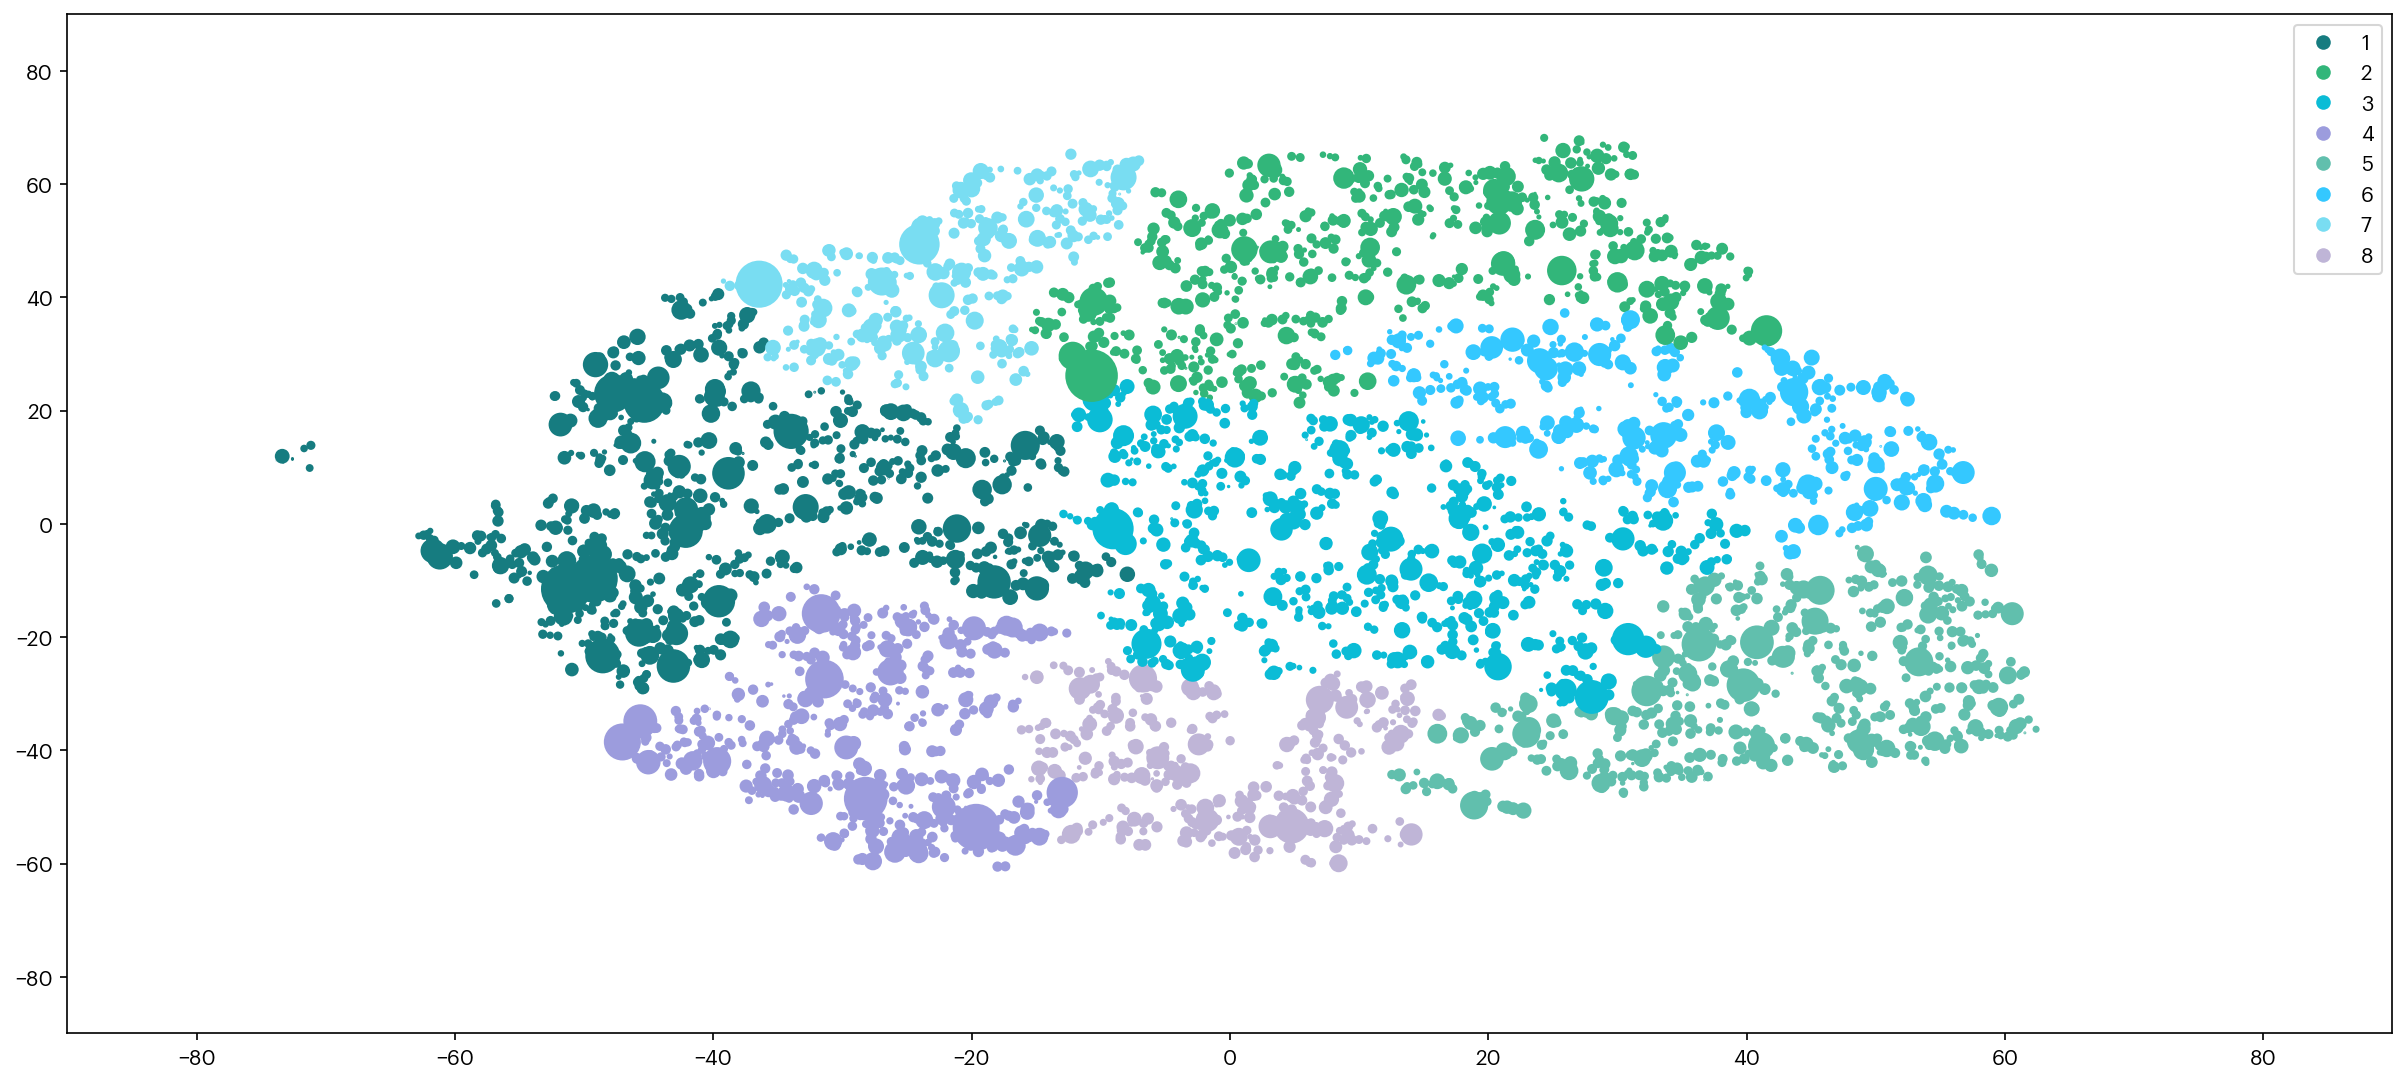

In [17]:
shs = [] 

for _,row in samples : shs.append( row["views"] )
shs = sklearn.preprocessing.normalize(  np.array([shs]) )[0]

plt.xlim(-90, 90)
plt.ylim(-90, 90)

plt.scatter(X, Y, c=[cls[l] for l in clusters.labels_], s=(shs * 25 * 100))
plt.legend(handles=hdl)
plt.show()

<br>Organise the personality data to perform cluster analysis and plot a heatmap of the traits

In [18]:
cfs = [ [],[],[],[],[],[],[],[] ] 
cfa = [ [],[],[],[],[],[],[],[] ] 
cft = [ [],[],[],[],[],[],[],[] ] 
cfx = [ [],[],[],[],[],[],[],[] ] 

for i,row in samples : row["cluster"] = clusters.labels_[i];
for i,row in samples :
    cft[ row["cluster"] ].extend(row["tags"])
    cfx[ row["cluster"] ].append(row["annotations_p"])

for i,f in enumerate(cfx): 
    for ll in f: 
        cfs[i].append( [x for _,_,x in ll["single"]] )
        cfa[i].append( project.unzip_array(ll["aggregated"])[1] )

In [19]:
csa = dict(); css = dict() 

for i, f in enumerate(cfs): css[i] = np.average(f, axis=0) 
for i, f in enumerate(cfa): csa[i] = np.average(f, axis=0)

print(personality_traits)
csa

['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']


{0: array([ 0.00514487,  0.15010121,  0.07490567, -0.00483523, -0.0728484 ]),
 1: array([ 0.13983163,  0.35385668,  0.38084859, -0.00600989, -0.12608285]),
 2: array([ 0.0135499 ,  0.12841579,  0.17214968, -0.1080371 ,  0.05356772]),
 3: array([ 0.00274401,  0.04578146,  0.0581724 , -0.0076966 , -0.01378805]),
 4: array([-0.01445288,  0.04660089,  0.03176202, -0.27404041,  0.17617465]),
 5: array([ 0.1074242 ,  0.26159916,  0.29134741, -0.17078183,  0.20927138]),
 6: array([ 0.01238391,  0.30877551,  0.15932432,  0.00910493, -0.14811143]),
 7: array([-0.00343925,  0.0411586 ,  0.02828886, -0.0813459 ,  0.02887036])}

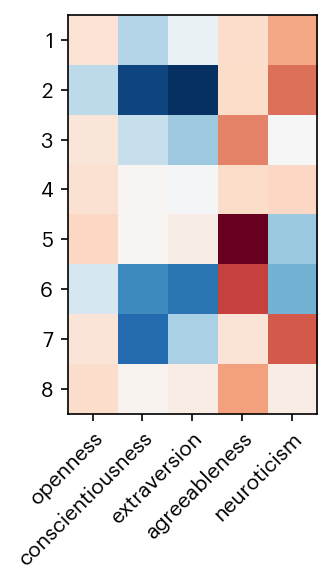

In [20]:
plt.rcParams["font.family"]    = "Graphik" 
plt.rcParams["figure.figsize"] = [ 3.0, 4.0 ]
plt.rcParams["figure.dpi"]     =   150

fig, ax = plt.subplots() 
im = ax.imshow(list(csa.values()), cmap=plt.get_cmap("RdBu"))

ax.set_xticks(np.arange( len(personality_traits) ), labels=personality_traits)
ax.set_yticks(np.arange( len(list(csa.keys()))   ), labels=list(range(1,9)))

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fig.tight_layout()
plt.show()

<br><br><b>Clusters' symbolic universes</b>

<br>Plot the semantic network of a specific cluster using the tags of its talks

In [21]:
nlp = spacy.load("en_core_web_lg") 

In [22]:
def extract_tags_from_cluster(n, q=3, mv=60): 
    
    rs = dict( collections.Counter( cft[n] ).most_common() )
    ks, vs  = project.unzip_array( rs.items() )
    
    sw = [ "tedx", "ted-ed", "ted-med" ]
    ks = [ nlp(k) for k in ks[:mv] if k not in sw ]
    mx = []
    
    for k1 in ks[:mv]:
        row = []
        
        for k2 in ks[:mv]:
            row.append( k1.similarity(k2) )
        mx.append(row)
    
    g = nx.Graph()
    
    for i, k1 in enumerate(ks[:mv]):
        g.add_weighted_edges_from([
            (k1, k2, mx[i][j]) for j, k2
            in enumerate(ks[:mv])
            if 0.6 < mx[i][j] < 1
        ])
    
    fig, ax = plt.subplots( figsize=(12,12), dpi=250 ) 
    
    pos = nx.spring_layout(g, seed=q)
    
    nds = sklearn.preprocessing.normalize( 
        np.array([[ rs[n.text] for n in g.nodes() ]])
    )[0]
    
    nx.draw(g, pos, **{
        "node_size": 0, "edge_color": (0,0,0,.02),
        "edgelist": list(g.edges())
    })
    
    nx.draw_networkx_nodes(g, pos, **{
        "node_size": (nds * 800),
        "node_color": "darkgray",
        "node_shape": "o", "alpha": (nds * 1.8),
        "nodelist": list(g.nodes()),
        "edgecolors": (0,0,0, .0)
    })
    
    nx.draw_networkx_edges(g, pos, **{
        "edge_color": ( 0,0,0, .04),
        "edgelist": list(g.edges())
    })
    
    nx.draw_networkx_labels(g, pos, **{
        "font_color": "black", "font_size": 6.5,
        "font_family": "Graphik", "alpha": .8,
        "horizontalalignment": "center",
        "verticalalignment": "bottom"
    })
    
    plt.show()

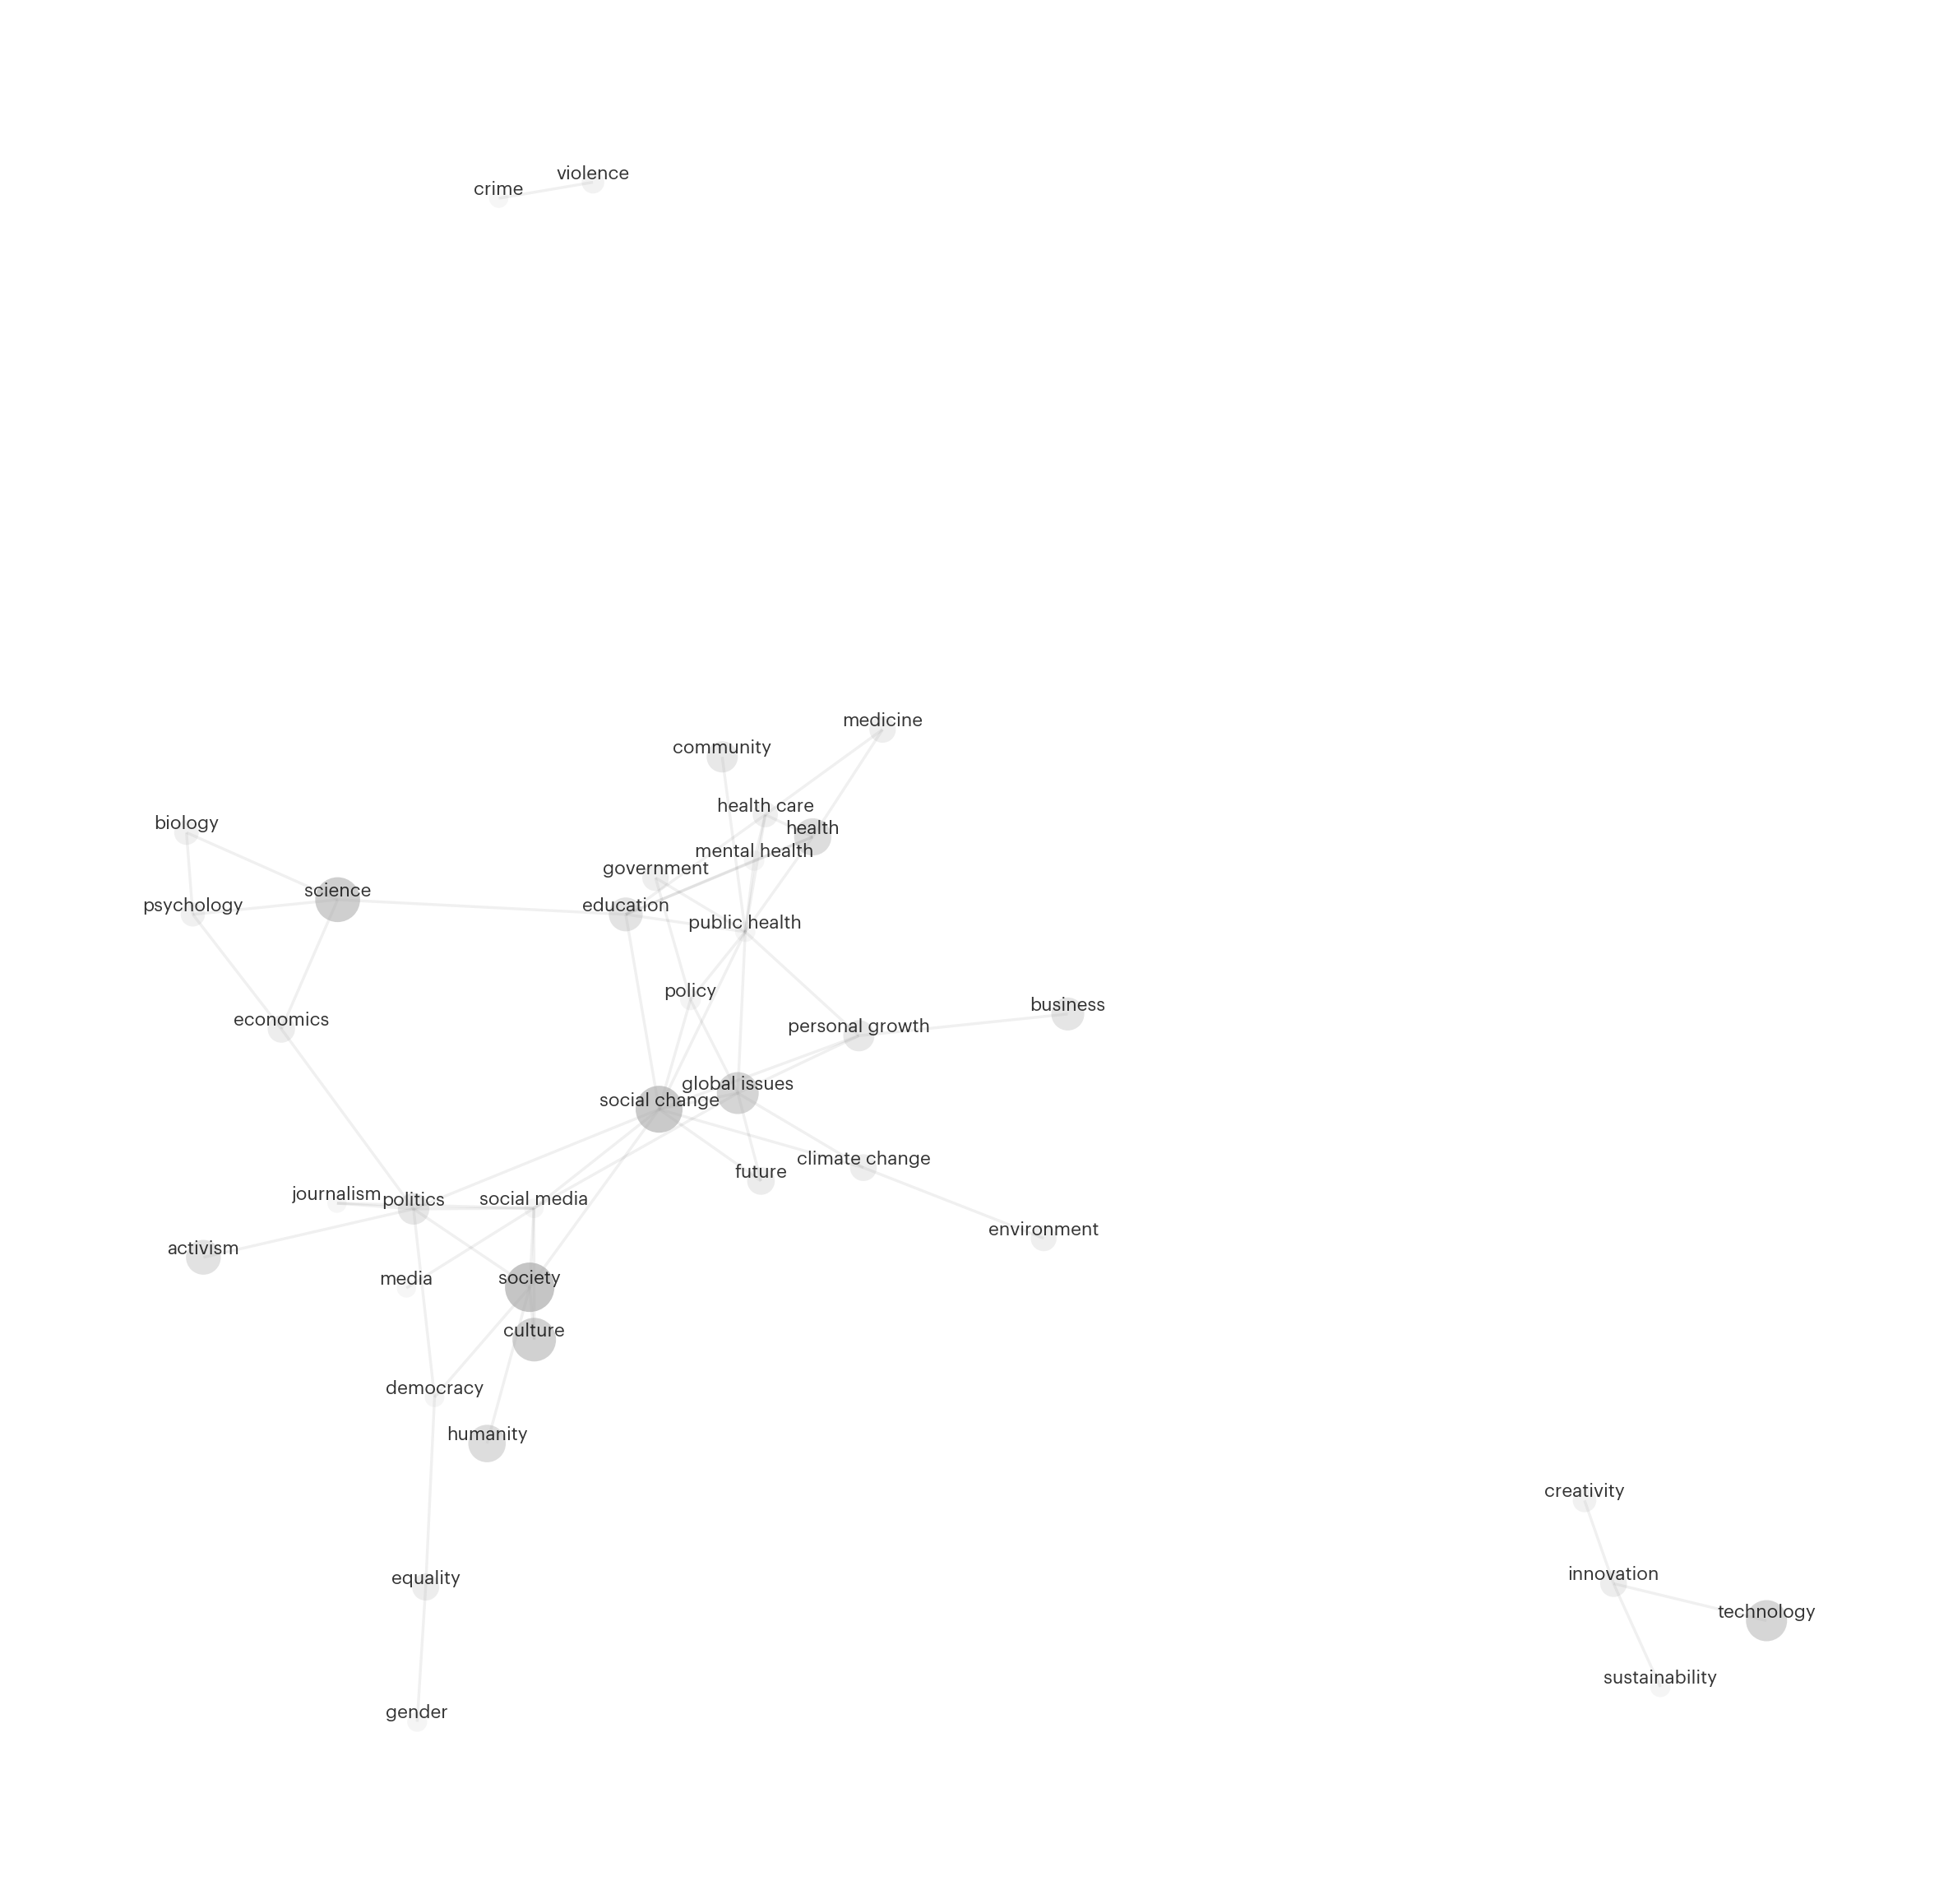

In [23]:
plt.rcParams["font.family"]    = "Graphik" 
plt.rcParams["figure.figsize"] = [ 2.0, 2.0 ]
plt.rcParams["figure.dpi"]     =   150

extract_tags_from_cluster(4, q=6)

In [24]:
def popular_titles_of_cluster(c): 
    
    vs = []
    for _,row in samples:
        if row["cluster"] == c:
            vs.append([ row["title"], row["views"] ])
    
    vs = sorted(vs, reverse=True, key=lambda x:x[1])
    vs = project.unzip_array(vs)[0][:10]
    
    return vs

popular_titles_of_cluster(4)

['The danger of a single story',
 'How I held my breath for 17 minutes',
 'The puzzle of motivation',
 'My escape from North Korea',
 'The price of shame',
 'Your elusive creative genius',
 'What makes you special?',
 'Everything you think you know about addiction is wrong',
 "What would happen if you didn't drink water?",
 'A simple way to break a bad habit']

<br><br>